# REGRESSION

In [35]:
import statsmodels.formula.api as smf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

sns.set_style('darkgrid')

## HELPER FUNCTIONS

In [2]:
def create_regressor_columns_string(columns):
  # Join all independent variables to define the formula used by the model
  regressor_columns = list(filter(lambda x: x != 'impression_count',columns))
  regressor_columns_string = "+".join(regressor_columns)
  return regressor_columns_string

In [3]:
def perform_regression(regression_df, significant_variables):
    # Define formula without cross terms
    regressor_columns_string = create_regressor_columns_string(significant_variables)
    # Fit model
    mod = smf.ols(formula=f'impression_count ~ {regressor_columns_string}', data=regression_df)
    res = mod.fit()
    return res

In [ ]:
def keep_significant_var(p_values):
    # Filter p-values < 0.05
    p_values = p_values[p_values < 0.05]

    # Get significant variables
    significant_variables = list(p_values.index)
    # Remove intercept if significant
    try:
        significant_variables.remove('Intercept')
    except:
        pass

    return significant_variables

## REGRESSIONS WITH LOG TRANSFORMED VARIABLES AND THRESHOLDING

In [8]:
def regression(path, threshold=1e2):
    # Load data
    regression_df_pd = pd.read_csv(path)
    regression_df_pd = regression_df_pd.drop('tweet_text', axis=1)
    
    #======================#
    #   FIRST REGRESSION   #
    #======================#
    significant_variables = list(regression_df_pd.columns)
    res = perform_regression(regression_df_pd, significant_variables)
    p_values = res.pvalues
    nb_variables_before = len(p_values)
    
    #======================#
    #   SECOND REGRESSION  #
    #======================#
    # Filter out data if impression_count < threshold
    regression_df_pd = regression_df_pd[regression_df_pd['impression_count'] >= threshold].copy()

    # Perform new regression with significant variables
    res_threshold = perform_regression(regression_df_pd, significant_variables)

    #======================#
    #   THIRD REGRESSION   #
    #======================#
    # Apply log transformation to independent variables
    for var in regression_df_pd.columns:
            regression_df_pd[var] = regression_df_pd[var].apply(lambda x: np.log(1+x))

    # Perform new regression with significant variables
    res_log = perform_regression(regression_df_pd, significant_variables)
    p_values = res_log.pvalues

    #======================#
    #   FINAL RESULTS      #
    #======================#
    # Filter p-values < 0.05
    significant_variables = keep_significant_var(p_values)
    nb_variables_after = len(significant_variables)

    # Perform new regression with significant variables
    res_final = perform_regression(regression_df_pd, significant_variables)

    print(f'Number of discarded variables: {nb_variables_before - nb_variables_after}')
    print(f'Significant variables ({len(significant_variables)}): {significant_variables}')

    #======================#
    #   SAVE AS HTML       #
    #======================#
    # Save first res as html
    res_html = res.summary().as_html()
    name = path.split('/')[-1].split('.')[0][:-3]
    path_root = os.path.join('/'.join(os.getcwd().split('/')[:-1]), "data", "regression", "html_regression")
    path = os.path.join(path_root, name+".html")
    with open(path, 'w') as f:
        f.write(res_html)

    # Save second res as html
    res_thresh_html = res_threshold.summary().as_html()
    path_opti = os.path.join(path_root, name+"_threshold.html")
    with open(path_opti, 'w') as f:
        f.write(res_thresh_html)

    # Save third res as html
    res_log_html = res_log.summary().as_html()
    path_log = os.path.join(path_root, name+"_log.html")
    with open(path_log, 'w') as f:
        f.write(res_log_html)

    # Save final res as html
    res_final_html = res_final.summary().as_html()
    path_final = os.path.join(path_root, name+"_final.html")
    with open(path_final, 'w') as f:
        f.write(res_final_html)

    return res, res_threshold, res_log, res_final

In [14]:
path_data = '../data/regression/american_celebrities_regression_df.csv'
res_reg = regression(path_data)

display(res_reg[0].summary())
display(res_reg[1].summary())
display(res_reg[2].summary())
display(res_reg[3].summary())

Number of discarded variables: 22
Significant variables (34): ['dummy_americanfootball', 'dummy_barstoolsports', 'dummy_basketball', 'dummy_businesspersonalities', 'dummy_competitionshows', 'dummy_events', 'dummy_foodbeveragebusiness', 'dummy_gamingbusiness', 'dummy_johncusack', 'dummy_kenjeong', 'dummy_lebronjames', 'dummy_moviestv', 'dummy_nbaplayers', 'dummy_pftcommenter', 'dummy_politicalfigures', 'dummy_pop', 'dummy_sports', 'dummy_sportsfigures', 'dummy_sportsicons', 'dummy_techpersonalities', 'dummy_television', 'dummy_thomassanders', 'dummy_tvmoviesrelatedentertainment', 'dummy_tweet_period_afternoon', 'dummy_tweet_period_morning', 'dummy_tweet_period_night', 'dummy_wizkhalifa', 'dummy_youtubers', 'hashtags_count', 'mentions_count', 'tweet_external_urls_count', 'tweet_length', 'tweet_medias_count', 'followers_count']


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       impression_count   R-squared:                       0.124
Model:                            OLS   Adj. R-squared:                  0.122
Method:                 Least Squares   F-statistic:                     70.14
Date:                Thu, 25 May 2023   Prob (F-statistic):               0.00
Time:                        09:19:41   Log-Likelihood:            -4.3831e+05
No. Observations:               26825   AIC:                         8.767e+05
Df Residuals:                   26770   BIC:                         8.772e+05
Df Model:                          54                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                           9.923e+04   4.11e+04      2.413      0.016    1.86e+04     1.8e+05
dummy_americanfootball              7.472e+05   1.29e+05      5.798      0.000    4.95e+05       1e+06
dummy_barstoolsports                1.208e+06   1.01e+06      1.197      0.231   -7.69e+05    3.18e+06
dummy_basketball                   -5.867e+04   2.06e+05     -0.284      0.776   -4.63e+05    3.46e+05
dummy_businessfinance              -2.551e+05   3.52e+05     -0.726      0.468   -9.44e+05    4.34e+05
dummy_businesspersonalities        -3.883e+05   1.36e+05     -2.852      0.004   -6.55e+05   -1.21e+05
dummy_celebrities                  -2.402e+05   8.44e+04     -2.846      0.004   -4.06e+05   -7.48e+04
dummy_competitionshows              -1.92e+05   1.91e+05     -1.004      0.315   -5.67e+05    1.83e+05
dummy_digitalcreators              -2.685e+05   3.61e+05     -0.745      0.456   -9.75e+05    4.38e+05
dummy_elonmusk                      1.619e+06   1.55e+06      1.043      0.297   -1.42e+06    4.66e+06
dummy_entertainment                -1.825e+05   9.29e+04     -1.965      0.049   -3.64e+05    -495.147
dummy_entertainmentleisurebusiness  1.151e+05   9.88e+04      1.166      0.244   -7.84e+04    3.09e+05
dummy_events                        6.214e+04    1.1e+05      0.567      0.571   -1.53e+05    2.77e+05
dummy_famouscomedians              -1.712e+05   7.54e+04     -2.272      0.023   -3.19e+05   -2.35e+04
dummy_financialservicesbusiness    -2.078e+05   3.02e+05     -0.689      0.491   -7.99e+05    3.84e+05
dummy_foodbeveragebusiness         -9750.4023   1.14e+05     -0.085      0.932   -2.34e+05    2.14e+05
dummy_gamingbusiness               -2.093e+05   1.14e+05     -1.833      0.067   -4.33e+05    1.45e+04
dummy_hiphop                        3.276e+05   6.83e+05      0.480      0.631   -1.01e+06    1.67e+06
dummy_jaketapper                    9.346e+04   1.87e+05      0.500      0.617   -2.73e+05     4.6e+05
dummy_johncusack                   -2.873e+05   1.02e+05     -2.830      0.005   -4.86e+05   -8.83e+04
dummy_journalists                  -1.992e+05    2.3e+05     -0.867      0.386   -6.49e+05    2.51e+05
dummy_kenjeong                     -4.782e+04   1.14e+05     -0.421      0.674    -2.7e+05    1.75e+05
dummy_leadership                    7731.1525   1.53e+06      0.005      0.996   -2.99e+06       3e+06
dummy_lebronjames                   9.349e+05    1.3e+05      7.210      0.000    6.81e+05    1.19e+06
dummy_moviestv                     -9.116e+04   1.47e+05     -0.622      0.534   -3.79e+05    1.96e+05
dummy_music                        -4.206e+05    1.3e+05     -3.228      0.001   -6.76e+05   -1.65e+05
dummy_nba                          -6.732e+05   3.87e+05     -1.738      0.082   -1.43e+06    8.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       impression_count   R-squared:                       0.137
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                     49.07
Date:                Thu, 25 May 2023   Prob (F-statistic):               0.00
Time:                        09:19:41   Log-Likelihood:            -2.7837e+05
No. Observations:               16812   AIC:                         5.569e+05
Df Residuals:                   16757   BIC:                         5.573e+05
Df Model:                          54                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                           1.454e+05   6.42e+04      2.266      0.023    1.96e+04    2.71e+05
dummy_americanfootball              7.251e+05   1.89e+05      3.835      0.000    3.55e+05     1.1e+06
dummy_barstoolsports                1.903e+06   1.54e+06      1.237      0.216   -1.11e+06    4.92e+06
dummy_basketball                   -2.605e+04   3.34e+05     -0.078      0.938   -6.81e+05    6.29e+05
dummy_businessfinance              -2.604e+05   5.01e+05     -0.520      0.603   -1.24e+06    7.22e+05
dummy_businesspersonalities         -4.25e+05   1.87e+05     -2.276      0.023   -7.91e+05   -5.89e+04
dummy_celebrities                  -1.282e+05   1.21e+05     -1.059      0.290   -3.65e+05    1.09e+05
dummy_competitionshows              -1.42e+05   3.01e+05     -0.472      0.637   -7.32e+05    4.48e+05
dummy_digitalcreators              -2.317e+05   5.62e+05     -0.412      0.680   -1.33e+06     8.7e+05
dummy_elonmusk                      2.213e+06   1.94e+06      1.138      0.255    -1.6e+06    6.02e+06
dummy_entertainment                -9.737e+04   1.55e+05     -0.628      0.530   -4.01e+05    2.07e+05
dummy_entertainmentleisurebusiness  5.123e+04   1.61e+05      0.319      0.750   -2.64e+05    3.66e+05
dummy_events                        8.362e+04   1.67e+05      0.500      0.617   -2.44e+05    4.11e+05
dummy_famouscomedians              -7.987e+04   1.12e+05     -0.712      0.476      -3e+05     1.4e+05
dummy_financialservicesbusiness    -3.251e+05   4.21e+05     -0.773      0.440   -1.15e+06       5e+05
dummy_foodbeveragebusiness         -7.919e+04   1.78e+05     -0.445      0.656   -4.28e+05     2.7e+05
dummy_gamingbusiness               -9093.7160    1.9e+05     -0.048      0.962   -3.82e+05    3.64e+05
dummy_hiphop                         1.63e+06   1.15e+06      1.414      0.157    -6.3e+05    3.89e+06
dummy_jaketapper                    1.468e+05   3.91e+05      0.375      0.708    -6.2e+05    9.14e+05
dummy_johncusack                   -6.475e+05   1.97e+05     -3.284      0.001   -1.03e+06   -2.61e+05
dummy_journalists                  -6.248e+05   4.44e+05     -1.408      0.159   -1.49e+06    2.45e+05
dummy_kenjeong                     -2.704e+05   2.07e+05     -1.303      0.192   -6.77e+05    1.36e+05
dummy_leadership                    2.005e+05   1.91e+06      0.105      0.916   -3.54e+06    3.94e+06
dummy_lebronjames                   4.668e+06   2.94e+05     15.851      0.000    4.09e+06    5.24e+06
dummy_moviestv                     -7.858e+04   2.28e+05     -0.344      0.731   -5.26e+05    3.69e+05
dummy_music                        -4.759e+05   2.08e+05     -2.293      0.022   -8.83e+05   -6.91e+04
dummy_nba                          -2.355e+05   7.57e+05     -0.311      0.756   -1.72e+06    1.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       impression_count   R-squared:                       0.628
Model:                            OLS   Adj. R-squared:                  0.627
Method:                 Least Squares   F-statistic:                     524.2
Date:                Thu, 25 May 2023   Prob (F-statistic):               0.00
Time:                        09:19:41   Log-Likelihood:                -31155.
No. Observations:               16812   AIC:                         6.242e+04
Df Residuals:                   16757   BIC:                         6.285e+04
Df Model:                          54                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                             -1.0012      0.143     -7.020      0.000      -1.281      -0.722
dummy_americanfootball                 1.3086      0.112     11.635      0.000       1.088       1.529
dummy_barstoolsports                   6.0492      0.913      6.629      0.000       4.261       7.838
dummy_basketball                       0.8883      0.198      4.483      0.000       0.500       1.277
dummy_businessfinance                  0.5657      0.297      1.904      0.057      -0.017       1.148
dummy_businesspersonalities           -1.3005      0.111    -11.708      0.000      -1.518      -1.083
dummy_celebrities                  -2.353e-05      0.073     -0.000      1.000      -0.144       0.144
dummy_competitionshows                -0.4762      0.179     -2.664      0.008      -0.827      -0.126
dummy_digitalcreators                 -0.1045      0.333     -0.313      0.754      -0.758       0.549
dummy_elonmusk                         1.7524      1.145      1.530      0.126      -0.492       3.997
dummy_entertainment                   -0.0623      0.092     -0.677      0.498      -0.242       0.118
dummy_entertainmentleisurebusiness     0.0323      0.095      0.338      0.735      -0.155       0.219
dummy_events                           0.3030      0.099      3.051      0.002       0.108       0.498
dummy_famouscomedians                  0.1155      0.069      1.668      0.095      -0.020       0.251
dummy_financialservicesbusiness       -0.2121      0.249     -0.850      0.395      -0.701       0.277
dummy_foodbeveragebusiness             0.3010      0.106      2.852      0.004       0.094       0.508
dummy_gamingbusiness                   0.3245      0.113      2.861      0.004       0.102       0.547
dummy_hiphop                           1.0647      0.683      1.558      0.119      -0.275       2.404
dummy_jaketapper                       0.3461      0.232      1.491      0.136      -0.109       0.801
dummy_johncusack                      -1.4421      0.117    -12.366      0.000      -1.671      -1.214
dummy_journalists                     -0.3683      0.263     -1.400      0.162      -0.884       0.147
dummy_kenjeong                        -0.4398      0.124     -3.545      0.000      -0.683      -0.197
dummy_leadership                      -0.1852      1.131     -0.164      0.870      -2.403       2.032
dummy_lebronjames                      1.4713      0.173      8.516      0.000       1.133       1.810
dummy_moviestv                         0.4992      0.135      3.692      0.000       0.234       0.764
dummy_music                           -0.1359      0.123     -1.104      0.270      -0.377       0.105
dummy_nba                              0.5911      0.449      1.316      0.188      -0.289      

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       impression_count   R-squared:                       0.625
Model:                            OLS   Adj. R-squared:                  0.625
Method:                 Least Squares   F-statistic:                     849.0
Date:                Thu, 25 May 2023   Prob (F-statistic):               0.00
Time:                        09:19:41   Log-Likelihood:                -31216.
No. Observations:               16812   AIC:                         6.250e+04
Df Residuals:                   16778   BIC:                         6.276e+04
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                             -1.1871      0.134     -8.849      0.000      -1.450      -0.924
dummy_americanfootball                 1.2657      0.112     11.279      0.000       1.046       1.486
dummy_barstoolsports                   6.0548      0.915      6.617      0.000       4.261       7.848
dummy_basketball                       1.1006      0.115      9.592      0.000       0.876       1.325
dummy_businesspersonalities           -1.2675      0.104    -12.165      0.000      -1.472      -1.063
dummy_competitionshows                -0.3885      0.151     -2.572      0.010      -0.685      -0.092
dummy_events                           0.2646      0.097      2.719      0.007       0.074       0.455
dummy_foodbeveragebusiness             0.3013      0.105      2.860      0.004       0.095       0.508
dummy_gamingbusiness                   0.3223      0.113      2.845      0.004       0.100       0.544
dummy_johncusack                      -1.4276      0.116    -12.319      0.000      -1.655      -1.200
dummy_kenjeong                        -0.4625      0.123     -3.765      0.000      -0.703      -0.222
dummy_lebronjames                      1.3637      0.172      7.917      0.000       1.026       1.701
dummy_moviestv                         0.4958      0.125      3.978      0.000       0.251       0.740
dummy_nbaplayers                       0.7365      0.127      5.806      0.000       0.488       0.985
dummy_pftcommenter                    -3.5822      0.919     -3.897      0.000      -5.384      -1.781
dummy_politicalfigures                 1.1841      0.075     15.813      0.000       1.037       1.331
dummy_pop                              0.2943      0.089      3.313      0.001       0.120       0.468
dummy_sports                           0.7398      0.098      7.518      0.000       0.547       0.933
dummy_sportsfigures                   -0.6703      0.126     -5.334      0.000      -0.917      -0.424
dummy_sportsicons                      0.4009      0.134      2.989      0.003       0.138       0.664
dummy_techpersonalities                4.4864      0.138     32.535      0.000       4.216       4.757
dummy_television                       0.4572      0.139      3.281      0.001       0.184       0.730
dummy_thomassanders                   -1.5474      0.305     -5.073      0.000      -2.145      -0.950
dummy_tvmoviesrelatedentertainment     0.9659      0.108      8.979      0.000       0.755       1.177
dummy_tweet_period_afternoon          -0.3659      0.044     -8.243      0.000      -0.453      -0.279
dummy_tweet_period_morning            -0.2667      0.054     -4.947      0.000      -0.372      -0.161
dummy_tweet_period_night              -0.1902      0.042     -4.559      0.000      -0.272      

## COEFFICIENTS PLOTS

In [200]:
# Assign significant levels stars to each variable name
def assign_stars(row):
    p_value = float(row['P>|t|'])
    name = row[0].replace('_', ' ').title()
    if p_value <= 0.01:
        return name + ' ***'
    elif p_value <= 0.05:
        return name + ' **'
    elif p_value <= 0.1:
        return name + ' *'
    else:
        return name

In [201]:
# Define function to output plot of the model coefficients

def coefplot(results):
    ### PREPARE DATA FOR PLOTTING
    # Create dataframe of results summary 
    coef_df = pd.DataFrame(results.summary().tables[1].data)
    
    # Add column names and drop the extra row with column labels
    coef_df.columns = coef_df.iloc[0]
    coef_df=coef_df.drop(0)

    # Rename column 0 and append * ** or *** for significance levels
    # coef_df["index"] = coef_df.apply(lambda x: assign_stars(x), axis=1)

    # Set index to variable names
    coef_df = coef_df.set_index(coef_df.apply(lambda x: assign_stars(x), axis=1))
    coef_df = coef_df.drop(coef_df.columns[0], axis=1)

    # Change datatype from object to float
    coef_df = coef_df.astype(float)

    # Get errors; (coef - lower bound of conf interval)
    errors = coef_df['coef'] - coef_df['[0.025']
    coef_df['errors'] = errors

    # Sort values by coef ascending
    coef_df = coef_df.sort_values(by=['coef'])

    ### PLOT COEFFICIENTS
    variables = list(coef_df.index.values)
    coef_df['variables'] = variables

    # Define figure, axes, and plot
    fig, ax = plt.subplots(figsize=(15, 10))
    
    # Error bars for 95% confidence interval
    # Can increase capsize to add whiskers
    coef_df.plot(x='variables', y='coef', kind='bar', ax=ax, color='none', fontsize=15, ecolor='steelblue', capsize=0, yerr='errors', legend=False)
    
    # Coefficients
    ax.scatter(x=np.arange(coef_df.shape[0]), marker='o', s=80, y=coef_df['coef'], color='steelblue')
    
    # Line to define zero on the y-axis
    ax.axhline(y=0, linestyle='--', color='red', linewidth=1)
    
    # Set title & labels
    #plt.title('Coefficients of Features - 95% Confidence Intervals',fontsize=20)
    ax.set_ylabel('Coefficients',fontsize=15)
    ax.set_xlabel('',fontsize=15)

    # Rotate y ticks and move to the right side
    ax.yaxis.tick_right()
    plt.yticks(rotation=90, fontsize=15)
    
    return plt.show()

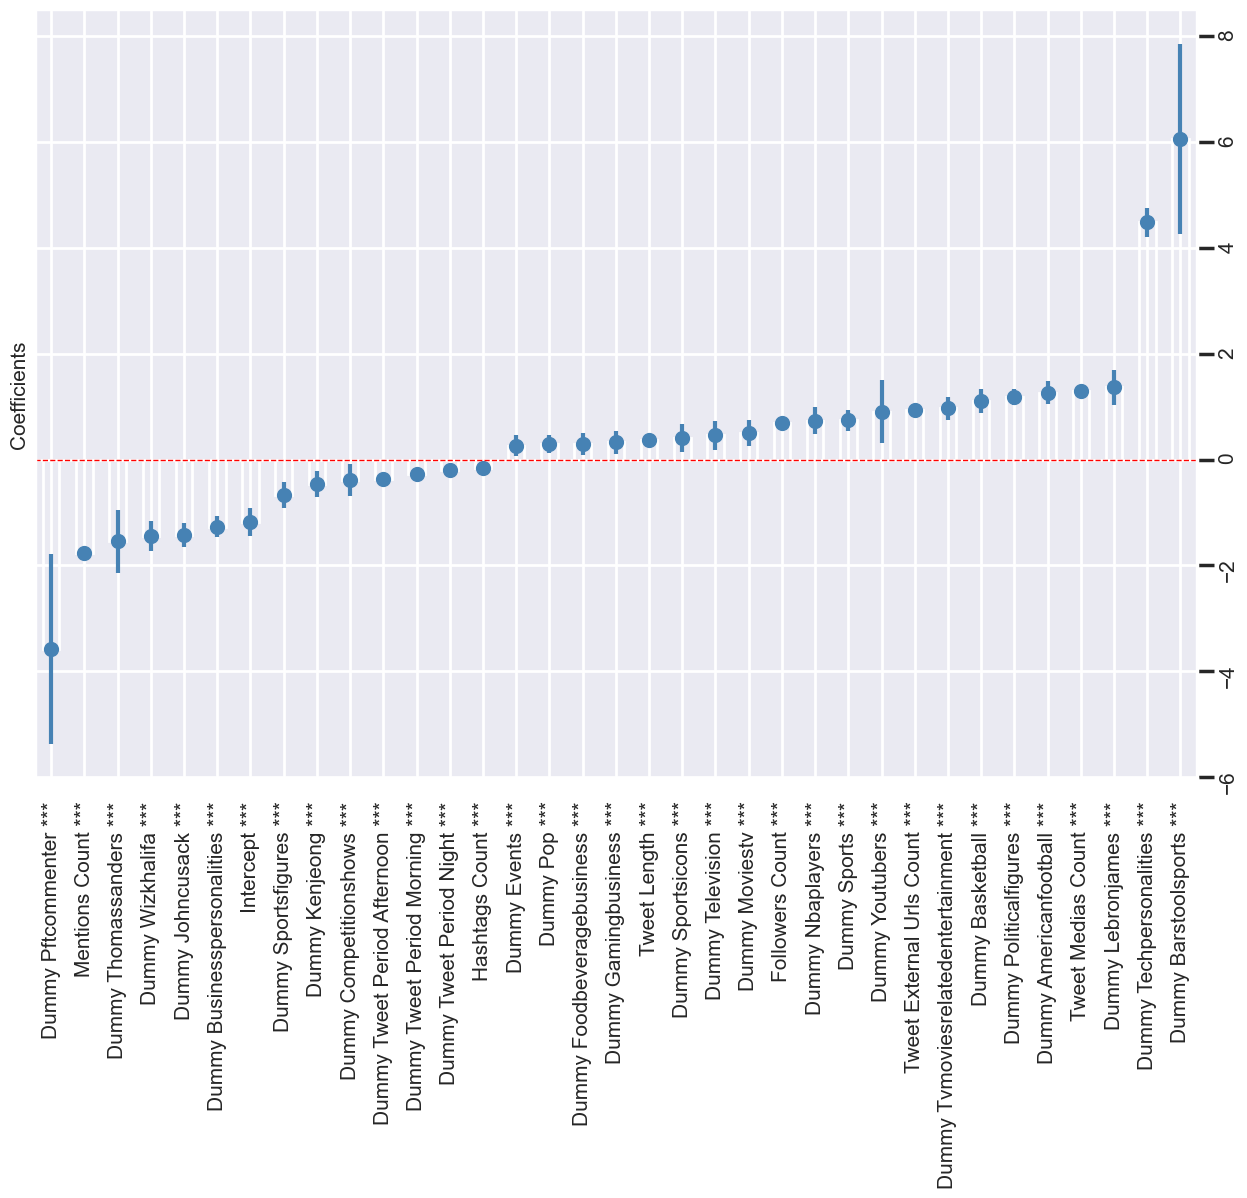

In [202]:
coefplot(res_reg[3])